In [8]:
# Install dependencies (run once)
# !pip install mellea qiskit qiskit-aer qiskit-ibm-runtime numpy matplotlib scipy

# MODULE 1: Quantum Circuit Generation Agent with Multi-Tier Evaluation

This module implements an LLM-driven quantum circuit generation agent backed by
**Mellea + Ollama**, paired with a comprehensive, literature-grounded evaluation
pipeline. The agent produces circuits as structured JSON, and the pipeline scores
them across seven tiers of increasing rigour:

| Tier | What it checks | Pass criterion |
|------|---------------|----------------|
| 1 | JSON schema validity | Parseable, required keys present, gate names legal |
| 2 | Compilation | Builds a `QuantumCircuit` without errors |
| 3 | Simulation | Runs on `AerSimulator`, returns non-trivial counts |
| 4 | OpenQASM 3.0 export | `qiskit.qasm3.dumps()` succeeds |
| 5 | Transpilation | Maps to ISA circuit for FakeSherbrooke, reports depth/ops |
| 6 | Hardware execution | Executes on FakeSherbrooke via `SamplerV2` |
| 7 | Physics metrics | Meyer-Wallach entanglement, Von Neumann entropy, distribution entropy, KL divergence |

**Design principles**
- Depth should be shallow; width (qubit count) is unconstrained.
- Every evaluation tier is an independent, reusable function.
- Metrics draw from recent literature: syntactic-correctness rate and KL divergence
  (Agent-Q, arXiv 2504.11109), Meyer-Wallach global entanglement measure
  (Macarone-Palmieri & Lo Franco, arXiv 2602.03466).

**Prerequisites** -- Ollama running locally with `granite3.3:2b` pulled.

## 1. Setup and Imports

In [9]:
import json
import math
import re
import textwrap
from typing import Any, Dict, List, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt

import mellea

from qiskit import QuantumCircuit
from qiskit import qasm3
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, entropy
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import SamplerV2 as Sampler

print("All imports loaded.")

All imports loaded.


## 2. Mellea Session Configuration

In [10]:
# ── LLM backend ──────────────────────────────────────────────────────────────
# Change model_id to match whatever you have pulled in Ollama.
# Alternatives: "granite4:tiny-h", "llama3.2:3b", "qwen2.5:3b"
MODEL_ID = "granite3.3:2b"

session = mellea.start_session(
    backend_name="ollama",
    model_id=MODEL_ID,
)
print(f"Mellea session started  --  model: {MODEL_ID}")

=== 02:00:31-INFO ======
Starting Mellea session: backend=ollama, model=granite3.3:2b, context=SimpleContext
Mellea session started  --  model: granite3.3:2b


## 3. Circuit JSON Schema

The LLM outputs circuits as JSON objects conforming to the schema below.
This intermediate representation is framework-agnostic and trivially
translatable to Qiskit, PennyLane, or OpenQASM 3.0.

In [11]:
# ── JSON schema description fed to the LLM ───────────────────────────────────
CIRCUIT_SCHEMA = """
You must output a quantum circuit as valid JSON:
{
  "num_qubits": <int>,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "cx", "control": 0, "target": 1},
    {"name": "rz", "targets": [1], "theta": "pi/4"}
  ]
}

Allowed gate names (case-insensitive):
  Single-qubit:  h, x, y, z
  Rotation:      rx, ry, rz  (requires "theta", e.g. "pi/4", 0.785, "pi/2")
  Two-qubit:     cx (CNOT), cz
  Measurement:   measure
"""

# Allowed gate names used for schema validation
ALLOWED_GATES = {"h", "x", "y", "z", "rx", "ry", "rz", "cx", "cnot", "cz", "measure"}

print("Circuit schema defined.")

Circuit schema defined.


## 4. LLM Circuit Generator

The system prompt enforces shallow depth (at most 10 gates) while leaving
qubit count unconstrained. The agent is instructed to avoid textbook circuits
and to output raw JSON with no surrounding prose.

In [12]:
# ── System prompt ─────────────────────────────────────────────────────────────
GENERATOR_SYSTEM_PROMPT = f"""You are a quantum algorithms researcher.

Your goal:
- Propose novel, compact quantum circuits.
- Focus on entanglement, interference, or variational structure.
- Avoid textbook circuits (Bell pair, GHZ, QFT).

Constraints:
- Use between 2 and 8 qubits.
- At most 10 gates total (keep the circuit shallow).
- Output valid JSON ONLY -- no markdown fences, no explanation.

{CIRCUIT_SCHEMA}"""


def generate_circuit(goal: str) -> str:
    """Ask the LLM to propose a circuit for *goal* and return the raw text."""
    prompt = (
        f"{GENERATOR_SYSTEM_PROMPT}\n\n"
        f"Task: Design a quantum circuit for: {goal}\n\n"
        "Respond with valid JSON only, no explanation."
    )
    response = session.instruct(prompt)
    return str(response)


print("Generator ready.")

Generator ready.


## 5. JSON Extraction and Parsing Utilities

Small helpers that bridge the gap between free-form LLM text and the
structured JSON we need. `extract_json` handles markdown code fences,
`parse_theta` handles symbolic expressions like `"pi/4"`.

In [13]:
def extract_json(text: str) -> str:
    """Return the first JSON object found in *text*.

    Handles:
      - ```json ... ``` code blocks
      - Bare { ... } objects
    """
    # Try code-block first
    m = re.search(r"```(?:json)?\s*(\{.*?\})\s*```", text, re.DOTALL)
    if m:
        return m.group(1)
    # Bare JSON
    m = re.search(r"\{[^{}]*(?:\{[^{}]*\}[^{}]*)*\}", text, re.DOTALL)
    if m:
        return m.group(0)
    return text


def parse_theta(value) -> float:
    """Convert a theta value (number or string like 'pi/4') to float radians."""
    if isinstance(value, (int, float)):
        return float(value)
    s = str(value).strip().replace("pi", str(math.pi)).replace("\u03c0", str(math.pi))
    try:
        return float(eval(s))
    except Exception:
        return math.pi / 4   # safe fallback


print("Parsing utilities ready.")

Parsing utilities ready.


## 6. Circuit Builder

Translates the JSON spec into a `qiskit.QuantumCircuit`. Qubit indices are
clamped so an out-of-range index from the LLM never crashes the build.

In [14]:
def build_qiskit_circuit(spec: dict) -> QuantumCircuit:
    """Build a QuantumCircuit from a JSON circuit specification.

    Handles flexible key naming the LLM might use ('targets' vs 'target',
    'control' vs 'controls', etc.).
    """
    n = spec["num_qubits"]
    qc = QuantumCircuit(n)

    def clamp(q: int) -> int:
        return max(0, min(int(q), n - 1))

    for gate in spec.get("gates", []):
        name = gate["name"].lower()

        # ── single-qubit gates ──────────────────────────────────────────
        if name in ("h", "x", "y", "z"):
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                getattr(qc, name)(clamp(t))

        # ── rotation gates ──────────────────────────────────────────────
        elif name in ("rx", "ry", "rz"):
            theta = parse_theta(gate.get("theta", "pi/4"))
            targets = gate.get("targets", gate.get("target", [0]))
            if isinstance(targets, int):
                targets = [targets]
            for t in targets:
                getattr(qc, name)(theta, clamp(t))

        # ── two-qubit gates ─────────────────────────────────────────────
        elif name in ("cx", "cnot"):
            ctrl = gate.get("control", gate.get("controls", [0]))
            tgt = gate.get("target", gate.get("targets", 1))
            if isinstance(ctrl, list):
                ctrl = ctrl[0]
            if isinstance(tgt, list):
                tgt = tgt[0]
            ctrl, tgt = clamp(ctrl), clamp(tgt)
            if ctrl == tgt:
                tgt = (ctrl + 1) % n
            qc.cx(ctrl, tgt)

        elif name == "cz":
            ctrl = gate.get("control", gate.get("controls", [0]))
            tgt = gate.get("target", gate.get("targets", 1))
            if isinstance(ctrl, list):
                ctrl = ctrl[0]
            if isinstance(tgt, list):
                tgt = tgt[0]
            ctrl, tgt = clamp(ctrl), clamp(tgt)
            if ctrl == tgt:
                tgt = (ctrl + 1) % n
            qc.cz(ctrl, tgt)

        # ── measure (ignored during statevector eval) ───────────────────
        elif name == "measure":
            pass   # measurements added explicitly when needed

    return qc


print("Circuit builder ready.")

Circuit builder ready.


---

## 7. Evaluation Tiers

Each tier is a standalone function that returns a dict with at least two keys:
`"pass"` (bool) and `"details"` (anything JSON-serialisable). Tiers are ordered
by cost: cheap sanity checks first, expensive hardware execution last.

### Tier 1 -- Schema and JSON Validation

In [15]:
def tier1_schema_validation(raw_text: str) -> Dict[str, Any]:
    """Tier 1: Parse JSON from LLM output and validate against the circuit schema.

    Checks:
      - JSON is syntactically valid.
      - Required keys 'num_qubits' and 'gates' are present.
      - Every gate name is in the allowed set.
      - num_qubits is a positive integer.

    Returns dict with keys 'pass', 'spec' (parsed dict or None), 'details'.
    """
    result: Dict[str, Any] = {"pass": False, "spec": None, "details": {}}

    # -- extract JSON --------------------------------------------------------
    try:
        json_str = extract_json(raw_text)
        spec = json.loads(json_str)
    except (json.JSONDecodeError, Exception) as exc:
        result["details"]["error"] = f"JSON parse error: {exc}"
        return result

    # -- required keys -------------------------------------------------------
    missing = [k for k in ("num_qubits", "gates") if k not in spec]
    if missing:
        result["details"]["error"] = f"Missing required keys: {missing}"
        result["spec"] = spec
        return result

    # -- num_qubits sanity ---------------------------------------------------
    if not isinstance(spec["num_qubits"], int) or spec["num_qubits"] < 1:
        result["details"]["error"] = f"num_qubits must be a positive int, got {spec['num_qubits']}"
        result["spec"] = spec
        return result

    # -- gate names ----------------------------------------------------------
    invalid_gates: List[str] = []
    for g in spec.get("gates", []):
        name = str(g.get("name", "")).lower()
        if name not in ALLOWED_GATES:
            invalid_gates.append(name)
    if invalid_gates:
        result["details"]["warning"] = f"Unknown gate names (will be skipped): {invalid_gates}"

    result["pass"] = True
    result["spec"] = spec
    result["details"]["num_qubits"] = spec["num_qubits"]
    result["details"]["num_gates"] = len(spec.get("gates", []))
    return result


print("Tier 1 (schema validation) ready.")

Tier 1 (schema validation) ready.


### Tier 2 -- Compilation Check

Build the Qiskit `QuantumCircuit` from the parsed JSON. If `build_qiskit_circuit`
raises, the circuit is syntactically broken.

In [16]:
def tier2_compilation(spec: dict) -> Dict[str, Any]:
    """Tier 2: Attempt to build a QuantumCircuit from the spec.

    Returns dict with 'pass', 'circuit' (QuantumCircuit or None), 'details'.
    """
    result: Dict[str, Any] = {"pass": False, "circuit": None, "details": {}}
    try:
        qc = build_qiskit_circuit(spec)
        result["pass"] = True
        result["circuit"] = qc
        result["details"]["depth"] = qc.depth()
        result["details"]["width"] = qc.num_qubits
        result["details"]["gate_counts"] = dict(qc.count_ops())
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 2 (compilation) ready.")

Tier 2 (compilation) ready.


### Tier 3 -- Simulator Execution

Run the circuit on `AerSimulator` with 1024 shots. A trivially broken circuit
would either crash here or return a single all-zeros outcome.

In [17]:
def tier3_simulation(qc: QuantumCircuit, shots: int = 1024) -> Dict[str, Any]:
    """Tier 3: Execute the circuit on AerSimulator.

    Returns dict with 'pass', 'counts', 'details'.
    A pass requires at least one non-zero count.
    """
    result: Dict[str, Any] = {"pass": False, "counts": {}, "details": {}}
    try:
        sim = AerSimulator()
        qc_m = qc.copy()
        qc_m.measure_all()
        job = sim.run(qc_m, shots=shots)
        counts = job.result().get_counts()
        result["counts"] = counts
        result["details"]["num_outcomes"] = len(counts)
        result["details"]["shots"] = shots
        result["pass"] = len(counts) > 0
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 3 (simulation) ready.")

Tier 3 (simulation) ready.


### Tier 4 -- OpenQASM 3.0 Export

Following Agent-Q (arXiv 2504.11109), syntactic correctness of the
OpenQASM 3.0 representation is a fundamental quality gate.

In [18]:
def tier4_qasm3_export(qc: QuantumCircuit) -> Dict[str, Any]:
    """Tier 4: Export the circuit to OpenQASM 3.0 and verify the string is non-empty.

    Mirrors the syntactic-correctness check used by Agent-Q (arXiv 2504.11109).
    """
    result: Dict[str, Any] = {"pass": False, "qasm3": "", "details": {}}
    try:
        qasm_str = qasm3.dumps(qc)
        result["qasm3"] = qasm_str
        result["details"]["length_chars"] = len(qasm_str)
        result["pass"] = len(qasm_str) > 0
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 4 (QASM 3.0 export) ready.")

Tier 4 (QASM 3.0 export) ready.


### Tier 5 -- Transpilation for Target Hardware

Transpile the logical circuit down to the native gate set and coupling map
of **FakeSherbrooke** (127-qubit Eagle r3). Reports ISA depth and gate
counts, which are direct proxies for expected noise.

In [19]:
def tier5_transpilation(
    qc: QuantumCircuit,
    backend=None,
    optimization_level: int = 3,
) -> Dict[str, Any]:
    """Tier 5: Transpile for a target backend.

    Returns ISA circuit, depth, gate counts, and two-qubit gate count
    (a key noise indicator).
    """
    result: Dict[str, Any] = {
        "pass": False,
        "isa_circuit": None,
        "details": {},
    }
    try:
        if backend is None:
            backend = FakeSherbrooke()

        pm = generate_preset_pass_manager(
            optimization_level=optimization_level,
            backend=backend,
        )
        isa = pm.run(qc)

        ops = dict(isa.count_ops())
        depth = isa.depth()
        two_q_count = sum(v for k, v in ops.items() if k in ("cx", "ecr", "cz", "rzz"))

        result["pass"] = True
        result["isa_circuit"] = isa
        result["details"]["isa_depth"] = depth
        result["details"]["isa_gate_counts"] = ops
        result["details"]["two_qubit_gate_count"] = two_q_count
        result["details"]["optimization_level"] = optimization_level
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 5 (transpilation) ready.")

Tier 5 (transpilation) ready.


### Tier 6 -- Hardware Execution (Fake Backend)

Execute the transpiled ISA circuit on `FakeSherbrooke` through `SamplerV2`.
This validates that the circuit survives the full Qiskit Runtime submission
path, including classical register handling and bit-array decoding.

In [49]:
from qiskit_aer.noise import NoiseModel

def _remove_idle_qubits(circuit: QuantumCircuit) -> Tuple[QuantumCircuit, List[int]]:
    """Return a copy of *circuit* with idle (unused) qubits removed.

    After transpilation to a 127-qubit backend like FakeSherbrooke, most
    qubits are idle.  Removing them makes AerSimulator execution feasible.

    Returns (compact_circuit, active_qubit_indices).
    """
    active_qubits = set()
    for inst in circuit.data:
        for qubit in inst.qubits:
            active_qubits.add(circuit.find_bit(qubit).index)

    active_list = sorted(active_qubits)

    if len(active_list) == circuit.num_qubits:
        return circuit, active_list

    qubit_map = {old: new for new, old in enumerate(active_list)}

    new_qc = QuantumCircuit(len(active_list))
    for inst in circuit.data:
        old_indices = [circuit.find_bit(q).index for q in inst.qubits]
        new_indices = [qubit_map[i] for i in old_indices]
        new_qc.append(inst.operation, new_indices)

    return new_qc, active_list


def tier6_hardware_execution(
    isa_circuit: QuantumCircuit,
    backend=None,
    shots: int = 4096,
) -> Dict[str, Any]:
    """Tier 6: Execute a transpiled ISA circuit with FakeSherbrooke noise.

    Removes idle qubits first (a 127-qubit ISA circuit with 3 active qubits
    would otherwise require 2^127 amplitudes), then runs AerSimulator with
    the FakeSherbrooke noise model so the results reflect realistic hardware
    error rates (T1/T2, gate errors, readout errors).
    """
    result: Dict[str, Any] = {"pass": False, "counts": {}, "details": {}}
    try:
        # Strip idle qubits
        compact, active_indices = _remove_idle_qubits(isa_circuit)

        qc = compact.copy()
        if qc.num_clbits == 0:
            qc.measure_all()

        # Build a noisy simulator from FakeSherbrooke
        fake_backend = FakeSherbrooke() if backend is None else backend
        noise_model = NoiseModel.from_backend(fake_backend)

        sim = AerSimulator(noise_model=noise_model)
        job = sim.run(qc, shots=shots)
        counts = job.result().get_counts()

        result["pass"] = len(counts) > 0
        result["counts"] = counts
        result["details"]["shots"] = shots
        result["details"]["num_outcomes"] = len(counts)
        result["details"]["active_qubits"] = compact.num_qubits
        result["details"]["original_isa_qubits"] = isa_circuit.num_qubits
        result["details"]["noise_model"] = True
    except Exception as exc:
        result["details"]["error"] = str(exc)
    return result


print("Tier 6 (hardware execution with noise model) ready.")

Tier 6 (hardware execution with noise model) ready.


### Tier 7 -- Physics-Based Quality Metrics

These metrics go beyond "does it run" and quantify the **physical quality** of
the generated state. They are drawn from two recent papers:

1. **Meyer-Wallach (MW) global entanglement** (Macarone-Palmieri & Lo Franco,
   arXiv 2602.03466): $Q(\psi)=\frac{4}{N}\sum_{i=1}^{N}(1-\text{Tr}[\rho_i^2])$,
   where $\rho_i$ is the reduced density matrix of qubit $i$. MW = 0 for product
   states, MW = 1 for maximally entangled states.

2. **Distribution entropy** (Shannon entropy of the measurement distribution) and
   **KL divergence** against a uniform reference (Agent-Q, arXiv 2504.11109).

3. **Von Neumann entanglement entropy** of single-qubit subsystems.

In [21]:
# ── individual metric helpers ─────────────────────────────────────────────────

def meyer_wallach(qc: QuantumCircuit) -> float:
    """Compute the Meyer-Wallach global entanglement measure.

    Q(psi) = (4/N) * sum_i (1 - Tr[rho_i^2])

    where rho_i is the reduced density matrix of qubit i.
    Range: 0 (product state) to 1 (maximally entangled).

    Reference: Meyer & Wallach, J. Math. Phys. 43, 4273 (2002);
               Macarone-Palmieri & Lo Franco, arXiv 2602.03466.
    """
    sv = Statevector.from_instruction(qc)
    rho = DensityMatrix(sv)
    n = qc.num_qubits
    if n < 2:
        return 0.0

    total = 0.0
    for i in range(n):
        trace_out = [j for j in range(n) if j != i]
        rho_i = partial_trace(rho, trace_out)
        purity = float(np.real(np.trace(rho_i.data @ rho_i.data)))
        total += 1.0 - purity

    return float(4.0 / n * total)


def entanglement_entropy(qc: QuantumCircuit, subsystem: List[int] = None) -> float:
    """Von Neumann entropy S(rho_A) of a subsystem (in bits).

    For a pure global state, S(rho_A) > 0 implies entanglement between A and
    its complement.  Defaults to subsystem = [0].
    """
    if subsystem is None:
        subsystem = [0]
    sv = Statevector.from_instruction(qc)
    rho = DensityMatrix(sv)
    n = qc.num_qubits
    trace_out = [i for i in range(n) if i not in subsystem]
    if not trace_out:
        return 0.0
    rho_sub = partial_trace(rho, trace_out)
    return float(entropy(rho_sub, base=2))


def distribution_entropy(counts: dict) -> float:
    """Shannon entropy H of the measurement distribution (in bits).

    H = -sum p_i log2(p_i).
    Maximum is log2(num_outcomes) for uniform distribution.
    """
    total = sum(counts.values())
    if total == 0:
        return 0.0
    h = 0.0
    for c in counts.values():
        if c > 0:
            p = c / total
            h -= p * math.log2(p)
    return h


def kl_divergence_vs_uniform(counts: dict) -> float:
    """KL divergence D_KL(P || U) of the measurement distribution P against
    the uniform distribution U over the same number of qubits.

    Lower means closer to uniform.
    Uses Laplace smoothing to avoid division by zero.

    Reference: Agent-Q evaluation (arXiv 2504.11109, Sec. IV-3).
    """
    n_qubits = len(next(iter(counts)))  # infer from bitstring length
    dim = 2 ** n_qubits
    total = sum(counts.values())
    if total == 0:
        return float("inf")

    u = 1.0 / dim   # uniform probability
    kl = 0.0
    for bitstring in range(dim):
        key = format(bitstring, f"0{n_qubits}b")
        p = (counts.get(key, 0) + 1) / (total + dim)   # Laplace smoothing
        kl += p * math.log2(p / u)
    return kl


# ── aggregated tier-7 function ───────────────────────────────────────────────

def tier7_physics_metrics(
    qc: QuantumCircuit,
    counts: dict,
) -> Dict[str, Any]:
    """Tier 7: Compute physics-based quality metrics.

    Computes:
      - Meyer-Wallach global entanglement
      - Mean single-qubit entanglement entropy
      - Distribution entropy (Shannon)
      - KL divergence vs uniform

    All are reported in 'details'; 'pass' is True when the circuit at least
    shows non-trivial entanglement (MW > 0.01) OR non-trivial distribution
    entropy.
    """
    result: Dict[str, Any] = {"pass": False, "details": {}}

    # -- Meyer-Wallach --------------------------------------------------------
    try:
        mw = meyer_wallach(qc)
    except Exception:
        mw = None
    result["details"]["meyer_wallach"] = mw

    # -- Entanglement entropy (average over single-qubit subsystems) ----------
    try:
        ee_values = [entanglement_entropy(qc, [i]) for i in range(qc.num_qubits)]
        ee_mean = float(np.mean(ee_values))
    except Exception:
        ee_values, ee_mean = [], None
    result["details"]["entanglement_entropy_per_qubit"] = ee_values
    result["details"]["entanglement_entropy_mean"] = ee_mean

    # -- Distribution entropy -------------------------------------------------
    try:
        de = distribution_entropy(counts)
    except Exception:
        de = None
    result["details"]["distribution_entropy"] = de

    # -- KL divergence vs uniform ---------------------------------------------
    try:
        kl = kl_divergence_vs_uniform(counts)
    except Exception:
        kl = None
    result["details"]["kl_divergence_vs_uniform"] = kl

    # -- pass criterion -------------------------------------------------------
    has_entanglement = (mw is not None and mw > 0.01)
    has_distribution = (de is not None and de > 0.5)
    result["pass"] = has_entanglement or has_distribution

    return result


print("Tier 7 (physics metrics) ready.")

Tier 7 (physics metrics) ready.


---

## 8. Unified Evaluation Pipeline

`evaluate_circuit` runs all seven tiers in sequence, short-circuiting early
if a prerequisite tier fails. It returns a single structured report dict.

In [50]:
def evaluate_circuit(
    raw_llm_output: str,
    run_hardware: bool = True,
    verbose: bool = True,
) -> Dict[str, Any]:
    """Run the full 7-tier evaluation pipeline on raw LLM text.

    Parameters
    ----------
    raw_llm_output : str
        The raw string returned by the LLM (may contain markdown fences, prose, etc.).
    run_hardware : bool
        If True, run tiers 5-6 (transpilation + fake-hardware execution).
    verbose : bool
        Print a line for each tier as it completes.

    Returns
    -------
    dict  with keys 'tier1' .. 'tier7', plus 'highest_tier_passed' (int 0-7).
    """
    report: Dict[str, Any] = {}
    highest = 0

    def _log(tier: int, name: str, passed: bool, extra: str = ""):
        if verbose:
            tag = "PASS" if passed else "FAIL"
            msg = f"  Tier {tier} [{name}]: {tag}"
            if extra:
                msg += f"  ({extra})"
            print(msg)

    # ── Tier 1 ──────────────────────────────────────────────────────────────
    t1 = tier1_schema_validation(raw_llm_output)
    report["tier1"] = t1
    _log(1, "Schema", t1["pass"],
         f"{t1['details'].get('num_qubits', '?')}q, {t1['details'].get('num_gates', '?')} gates")
    if not t1["pass"]:
        report["highest_tier_passed"] = highest
        return report
    highest = 1

    # ── Tier 2 ──────────────────────────────────────────────────────────────
    t2 = tier2_compilation(t1["spec"])
    report["tier2"] = t2
    _log(2, "Compilation", t2["pass"],
         f"depth={t2['details'].get('depth', '?')}")
    if not t2["pass"]:
        report["highest_tier_passed"] = highest
        return report
    highest = 2

    # ── Tier 3 ──────────────────────────────────────────────────────────────
    t3 = tier3_simulation(t2["circuit"])
    report["tier3"] = t3
    _log(3, "Simulation", t3["pass"],
         f"{t3['details'].get('num_outcomes', 0)} distinct outcomes")
    if not t3["pass"]:
        report["highest_tier_passed"] = highest
        return report
    highest = 3

    # ── Tier 4 ──────────────────────────────────────────────────────────────
    t4 = tier4_qasm3_export(t2["circuit"])
    report["tier4"] = t4
    _log(4, "QASM 3.0", t4["pass"],
         f"{t4['details'].get('length_chars', 0)} chars")
    if not t4["pass"]:
        report["highest_tier_passed"] = highest
        return report
    highest = 4

    # ── Tier 5 ──────────────────────────────────────────────────────────────
    if run_hardware:
        t5 = tier5_transpilation(t2["circuit"])
        report["tier5"] = t5
        _log(5, "Transpilation", t5["pass"],
             f"ISA depth={t5['details'].get('isa_depth', '?')}, "
             f"2q gates={t5['details'].get('two_qubit_gate_count', '?')}")
        if not t5["pass"]:
            report["highest_tier_passed"] = highest
            return report
        highest = 5

        # ── Tier 6 ──────────────────────────────────────────────────────────
        t6 = tier6_hardware_execution(t5["isa_circuit"])
        report["tier6"] = t6
        _log(6, "Hardware Exec", t6["pass"],
             f"{t6['details'].get('num_outcomes', 0)} outcomes")
        if not t6["pass"]:
            report["highest_tier_passed"] = highest
            return report
        highest = 6
    else:
        if verbose:
            print("  Tiers 5-6 skipped (run_hardware=False).")

    # ── Tier 7 ──────────────────────────────────────────────────────────────
    t7 = tier7_physics_metrics(t2["circuit"], t3["counts"])
    report["tier7"] = t7
    mw = t7["details"].get("meyer_wallach")
    de = t7["details"].get("distribution_entropy")
    _log(7, "Physics", t7["pass"],
         f"MW={mw:.4f}, H={de:.3f} bits" if mw is not None and de is not None else "")
    if t7["pass"]:
        highest = 7

    report["highest_tier_passed"] = highest
    return report


print("Unified evaluation pipeline ready.")

Unified evaluation pipeline ready.


## 9. Report Printer and Visualization

In [23]:
def print_report(report: Dict[str, Any]) -> None:
    """Pretty-print the evaluation report to stdout."""
    ht = report.get("highest_tier_passed", 0)
    print("=" * 65)
    print(f"  EVALUATION REPORT  --  highest tier passed: {ht} / 7")
    print("=" * 65)

    # Tier 1
    if "tier1" in report:
        t = report["tier1"]
        print(f"\n[Tier 1  Schema]  pass={t['pass']}")
        if t.get("spec"):
            print(f"  num_qubits = {t['spec'].get('num_qubits')}")
            print(f"  num_gates  = {len(t['spec'].get('gates', []))}")

    # Tier 2
    if "tier2" in report:
        t = report["tier2"]
        print(f"\n[Tier 2  Compilation]  pass={t['pass']}")
        if t["pass"]:
            print(f"  logical depth      = {t['details']['depth']}")
            print(f"  logical gate counts = {t['details']['gate_counts']}")

    # Tier 3
    if "tier3" in report:
        t = report["tier3"]
        print(f"\n[Tier 3  Simulation]  pass={t['pass']}")
        if t["pass"]:
            print(f"  distinct outcomes = {t['details']['num_outcomes']}")
            top3 = sorted(t["counts"].items(), key=lambda x: -x[1])[:3]
            print(f"  top-3 outcomes    = {top3}")

    # Tier 4
    if "tier4" in report:
        t = report["tier4"]
        print(f"\n[Tier 4  QASM 3.0]  pass={t['pass']}")
        if t["pass"]:
            print(f"  QASM length = {t['details']['length_chars']} chars")

    # Tier 5
    if "tier5" in report:
        t = report["tier5"]
        print(f"\n[Tier 5  Transpilation]  pass={t['pass']}")
        if t["pass"]:
            print(f"  ISA depth         = {t['details']['isa_depth']}")
            print(f"  2-qubit gate count = {t['details']['two_qubit_gate_count']}")
            print(f"  ISA gate counts    = {t['details']['isa_gate_counts']}")

    # Tier 6
    if "tier6" in report:
        t = report["tier6"]
        print(f"\n[Tier 6  Hardware Exec]  pass={t['pass']}")
        if t["pass"]:
            print(f"  distinct outcomes = {t['details']['num_outcomes']}")

    # Tier 7
    if "tier7" in report:
        t = report["tier7"]
        d = t["details"]
        print(f"\n[Tier 7  Physics Metrics]  pass={t['pass']}")
        if d.get("meyer_wallach") is not None:
            print(f"  Meyer-Wallach          = {d['meyer_wallach']:.6f}")
        if d.get("entanglement_entropy_mean") is not None:
            print(f"  Entanglement entropy   = {d['entanglement_entropy_mean']:.6f}  (mean over qubits)")
        if d.get("distribution_entropy") is not None:
            print(f"  Distribution entropy   = {d['distribution_entropy']:.4f} bits")
        if d.get("kl_divergence_vs_uniform") is not None:
            print(f"  KL div vs uniform      = {d['kl_divergence_vs_uniform']:.6f}")

    print("\n" + "=" * 65)


def plot_evaluation(report: Dict[str, Any], title: str = "") -> None:
    """Visualise the measurement distribution and tier summary."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # -- left panel: measurement distribution --------------------------------
    counts = {}
    if "tier3" in report and report["tier3"]["pass"]:
        counts = report["tier3"]["counts"]

    if counts:
        states = list(counts.keys())
        vals = list(counts.values())
        axes[0].bar(states, vals, color="steelblue", edgecolor="black")
        axes[0].set_xlabel("Bitstring")
        axes[0].set_ylabel("Counts")
        axes[0].set_title("Simulator Measurement Distribution")
        if len(states) > 8:
            axes[0].tick_params(axis="x", rotation=45)
    else:
        axes[0].text(0.5, 0.5, "No simulation data", ha="center", va="center",
                     transform=axes[0].transAxes)
        axes[0].set_title("Simulator Measurement Distribution")

    # -- right panel: tier pass/fail bar chart --------------------------------
    tier_names = ["Schema", "Compile", "Simulate", "QASM3", "Transpile", "HW Exec", "Physics"]
    tier_keys = [f"tier{i}" for i in range(1, 8)]
    colours = []
    for k in tier_keys:
        if k in report:
            colours.append("seagreen" if report[k]["pass"] else "indianred")
        else:
            colours.append("lightgrey")

    y_pos = np.arange(len(tier_names))
    axes[1].barh(y_pos, [1]*7, color=colours, edgecolor="black")
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(tier_names)
    axes[1].set_xlim(0, 1.2)
    axes[1].set_xticks([])
    for i, k in enumerate(tier_keys):
        if k in report:
            label = "PASS" if report[k]["pass"] else "FAIL"
            axes[1].text(1.05, i, label, va="center", fontsize=9,
                         color="seagreen" if report[k]["pass"] else "indianred")
    axes[1].set_title("Tier Pass / Fail Summary")

    if title:
        fig.suptitle(title, fontsize=12)
    plt.tight_layout()
    plt.show()


print("Report + visualisation utilities ready.")

Report + visualisation utilities ready.


---

## 10. Demo: Generate and Evaluate

Below we ask the LLM to produce a circuit for a specific goal, then pass its
raw output through every evaluation tier. The full report and visualisation
are printed at the end.

In [41]:
# ── Step 1: Ask the LLM to generate a circuit ────────────────────────────────
GOAL = "Create an entangling circuit that produces a non-trivial superposition over 3 qubits"

session.reset()
raw_output = generate_circuit(GOAL)

print(f"Goal: {GOAL}\n")
print(f"Raw LLM output:\n{raw_output}")

  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:07:25-INFO ======
SUCCESS


  0%|          | 0/2 [00:06<?, ?it/s]

Goal: Create an entangling circuit that produces a non-trivial superposition over 3 qubits

Raw LLM output:
{
  "num_qubits": 3,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "cx", "control": 0, "target": 1},
    {"name": "rz", "targets": [1], "theta": "pi/2"},
    {"name": "cx", "control": 0, "target": 2}
  ]
}


In [51]:
# ── Step 2: Run the full evaluation pipeline ──────────────────────────────────
print("Running 7-tier evaluation ...\n")
report = evaluate_circuit(raw_output, run_hardware=True, verbose=True)

Running 7-tier evaluation ...

  Tier 1 [Schema]: PASS  (3q, 4 gates)
  Tier 2 [Compilation]: PASS  (depth=3)
  Tier 3 [Simulation]: PASS  (2 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (103 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=11, 2q gates=2)
  Tier 6 [Hardware Exec]: PASS  (8 outcomes)
  Tier 7 [Physics]: PASS  (MW=2.0000, H=1.000 bits)


In [26]:
# ── Step 3: Print the full report ─────────────────────────────────────────────
print_report(report)

  EVALUATION REPORT  --  highest tier passed: 5 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 3
  num_gates  = 4

[Tier 2  Compilation]  pass=True
  logical depth      = 2
  logical gate counts = {'h': 1, 'cx': 1, 'rz': 1, 'cz': 1}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 2
  top-3 outcomes    = [('000', 539), ('001', 485)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 103 chars

[Tier 5  Transpilation]  pass=True
  ISA depth         = 7
  2-qubit gate count = 1
  ISA gate counts    = {'rz': 10, 'sx': 5, 'ecr': 1}

[Tier 6  Hardware Exec]  pass=False



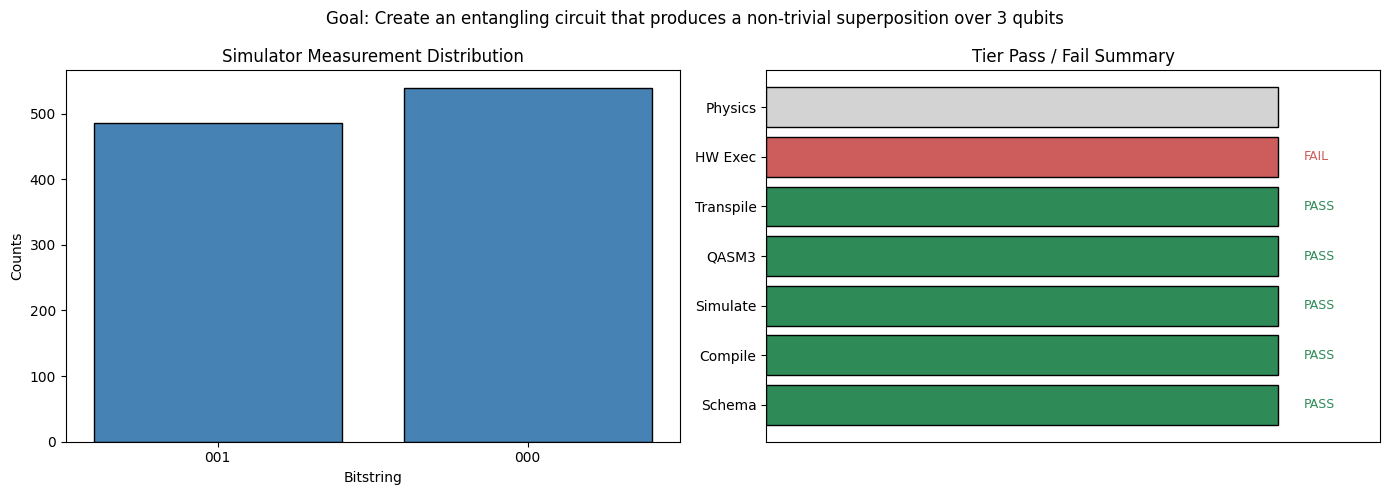

In [27]:
# ── Step 4: Visualise ─────────────────────────────────────────────────────────
plot_evaluation(report, title=f"Goal: {GOAL}")

In [28]:
# ── Step 5: Show the circuit diagram and QASM ────────────────────────────────
if "tier2" in report and report["tier2"]["pass"]:
    qc = report["tier2"]["circuit"]
    print("Circuit diagram:\n")
    print(qc.draw(output="text"))

if "tier4" in report and report["tier4"]["pass"]:
    print("\nOpenQASM 3.0 export:\n")
    print(report["tier4"]["qasm3"])

Circuit diagram:

     ┌───┐┌─────────┐
q_0: ┤ H ├┤ Rz(π/4) ├
     └───┘└─────────┘
q_1: ──■───────■─────
     ┌─┴─┐     │     
q_2: ┤ X ├─────■─────
     └───┘           

OpenQASM 3.0 export:

OPENQASM 3.0;
include "stdgates.inc";
qubit[3] q;
h q[0];
cx q[1], q[2];
rz(pi/4) q[0];
cz q[2], q[1];



---

## 10b. Complex Stress Tests

Push the LLM with harder, physics-specific prompts that require multi-qubit
entanglement, specific interference patterns, and variational structure.

In [52]:
COMPLEX_GOALS = [
    # ── Multi-qubit entanglement with specific structure ──────────────────
    "Design a 6-qubit circuit that creates a W-state-like superposition where "
    "exactly one qubit is in |1⟩ at a time, using only H, CNOT, and X gates. "
    "The output distribution should have 6 peaks of roughly equal probability.",

    # ── Variational ansatz with entanglement layers ──────────────────────
    "Build an 8-qubit hardware-efficient variational ansatz with two alternating "
    "layers: (1) single-qubit Ry rotations on all qubits with angles pi/3, pi/5, "
    "pi/7, pi/11, pi/13, pi/4, pi/6, pi/8, then (2) a CNOT entangling ladder "
    "connecting qubit 0→1→2→3→4→5→6→7. Keep total gate count under 10.",

    # ── Interference / phase kickback ────────────────────────────────────
    "Construct a 4-qubit circuit that demonstrates quantum phase kickback: "
    "apply H to qubit 0, use it as control for CZ gates on qubits 1, 2, and 3, "
    "then apply H to qubit 0 again. The goal is for qubit 0 to flip phase based "
    "on the target qubits' state.",

    # ── Approximate quantum error detection ──────────────────────────────
    "Create a 5-qubit circuit that encodes a logical qubit into 3 physical qubits "
    "(qubits 0-2) using CNOT entanglement, then applies an X error on qubit 1, "
    "and finally uses qubits 3-4 as syndrome ancillas with CNOT to detect the error. "
    "The measurement of qubits 3 and 4 should reveal the error location.",

    # ── Maximally entangled state with rotation diversity ────────────────
    "Propose a 5-qubit circuit that achieves Meyer-Wallach entanglement above 0.8 "
    "using a combination of H, Rz(pi/3), Ry(pi/5), and CNOT gates arranged in a "
    "non-trivial topology (not just a linear chain). Aim for a roughly uniform "
    "measurement distribution across at least 8 distinct bitstrings.",
]

print(f"Prepared {len(COMPLEX_GOALS)} complex stress-test goals.")

Prepared 5 complex stress-test goals.



  COMPLEX TEST 1/5
  Goal: Design a 6-qubit circuit that creates a W-state-like superposition where exactly...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:18:00-INFO ======
SUCCESS


  0%|          | 0/2 [00:23<?, ?it/s]

Raw LLM output:
{
  "num_qubits": 6,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "cx", "control": 1, "target": 2},
    {"name": "cx", "control": 2, "target": 3},
    {"name": "cx", "control": 3, "target": 4},
    {"name": "cx", "control": 4, "target": 5},
    {"name": "h", "targets": [5]}
  ]
}

  Tier 1 [Schema]: PASS  (6q, 6 gates)
  Tier 2 [Compilation]: PASS  (depth=5)
  Tier 3 [Simulation]: PASS  (4 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (126 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=15, 2q gates=4)


  Tier 6 [Hardware Exec]: PASS  (44 outcomes)
  Tier 7 [Physics]: PASS  (MW=0.0000, H=1.997 bits)
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 6
  num_gates  = 6

[Tier 2  Compilation]  pass=True
  logical depth      = 5
  logical gate counts = {'cx': 4, 'h': 2}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 4
  top-3 outcomes    = [('100000', 270), ('000001', 265), ('000000', 259)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 126 chars

[Tier 5  Transpilation]  pass=True
  ISA depth         = 15
  2-qubit gate count = 4
  ISA gate counts    = {'rz': 18, 'sx': 9, 'ecr': 4, 'x': 3}

[Tier 6  Hardware Exec]  pass=True
  distinct outcomes = 44

[Tier 7  Physics Metrics]  pass=True
  Meyer-Wallach          = 0.000000
  Entanglement entropy   = 0.000000  (mean over qubits)
  Distribution entropy   = 1.9973 bits
  KL div vs uniform      = 3.479207



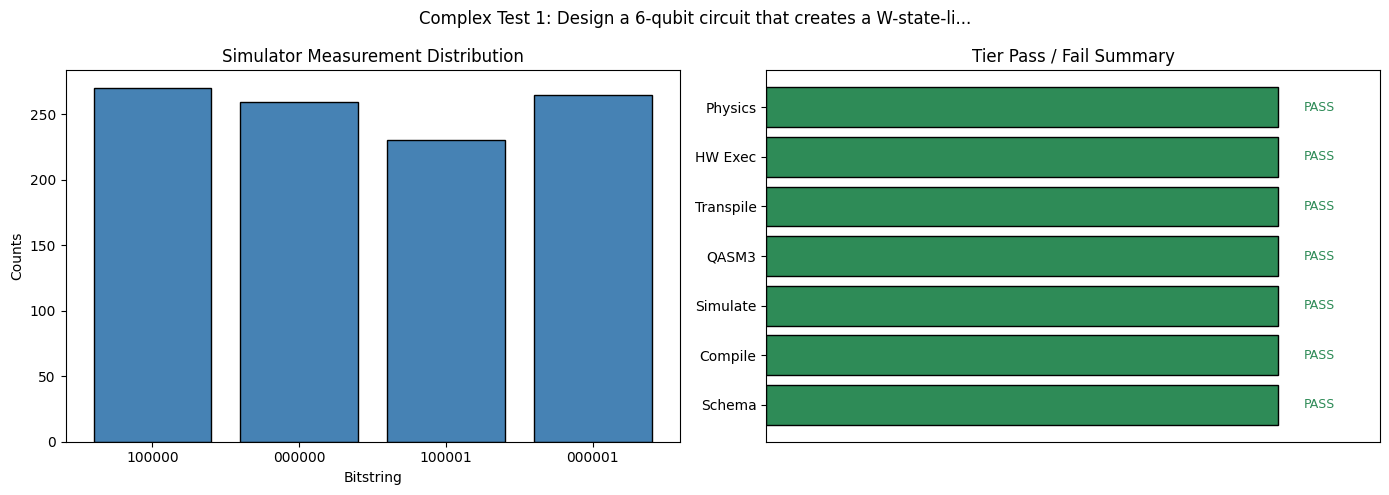


  COMPLEX TEST 2/5
  Goal: Build an 8-qubit hardware-efficient variational ansatz with two alternating laye...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:18:27-INFO ======
SUCCESS


  0%|          | 0/2 [00:23<?, ?it/s]

Raw LLM output:
{
  "num_qubits": 8,
  "gates": [
    {"name": "ry", "targets": [0], "theta": "pi/3"},
    {"name": "ry", "targets": [1], "theta": "pi/5"},
    {"name": "ry", "targets": [2], "theta": "pi/7"},
    {"name": "ry", "targets": [3], "theta": "pi/11"},
    {"name": "ry", "targets": [4], "theta": "pi/13"},
    {"name": "ry", "targets": [5], "theta": "pi/4"},
    {"name": "ry", "targets": [6], "theta": "pi/6"},
    {"name": "ry", "targets": [7], "theta": "pi/8"},
    {"name": "cz", "control": 0, "target": 1},
    {"name": "cz", "control": 1, "target": 2},
    {"name": "cz", "control": 2, "target": 3},
    {"name": "cz", "control": 3, "target": 4},
    {"name": "cz", "control": 4, "target": 5},
    {"name": "cz", "control": 5, "target": 6},
    {"name": "cz", "control": 6, "target": 7}
  ]
}

  Tier 1 [Schema]: PASS  (8q, 15 gates)
  Tier 2 [Compilation]: PASS  (depth=8)


  Tier 3 [Simulation]: PASS  (37 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (277 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=32, 2q gates=7)
  Tier 6 [Hardware Exec]: PASS  (105 outcomes)
  Tier 7 [Physics]: PASS  (MW=0.2463, H=2.763 bits)
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 8
  num_gates  = 15

[Tier 2  Compilation]  pass=True
  logical depth      = 8
  logical gate counts = {'ry': 8, 'cz': 7}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 37
  top-3 outcomes    = [('00000000', 524), ('00000001', 148), ('00100000', 90)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 277 chars

[Tier 5  Transpilation]  pass=True
  ISA depth         = 32
  2-qubit gate count = 7
  ISA gate counts    = {'rz': 28, 'sx': 24, 'ecr': 7, 'x': 3}

[Tier 6  Hardware Exec]  pass=True
  distinct outcomes = 105

[Tier 7  Physics Metrics]  pass=True
  Meyer-Wallach          = 0.246313
  Entanglement entropy   = 0.191235  (mean over qubits)

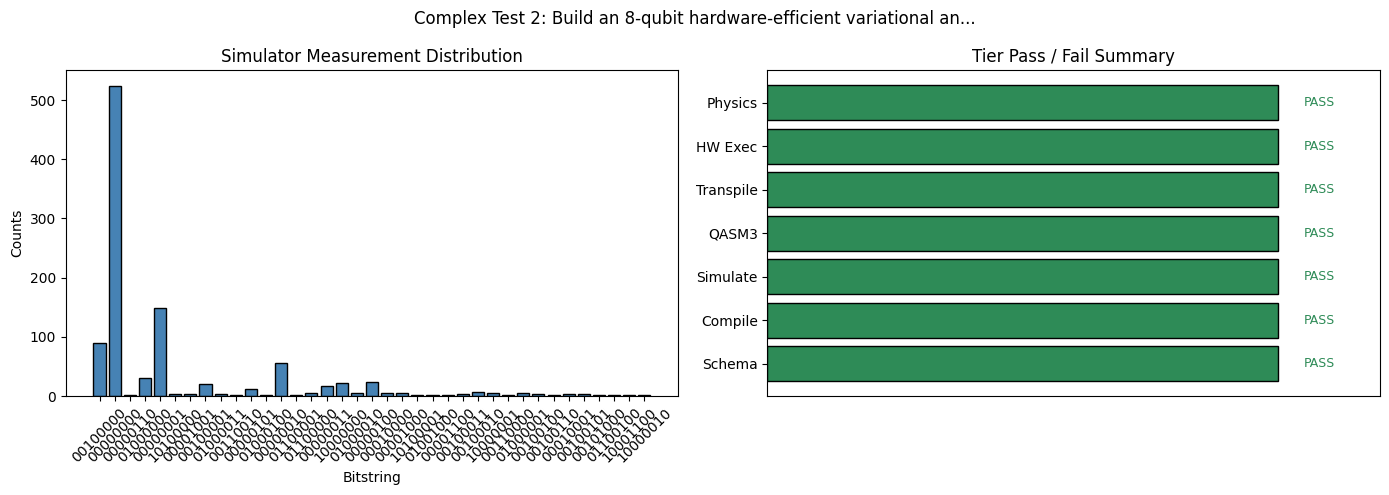


  COMPLEX TEST 3/5
  Goal: Construct a 4-qubit circuit that demonstrates quantum phase kickback: apply H to...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:18:41-INFO ======
SUCCESS


  0%|          | 0/2 [00:10<?, ?it/s]

Raw LLM output:
{
  "num_qubits": 4,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "cz", "control": 0, "target": 1},
    {"name": "cz", "control": 0, "target": 2},
    {"name": "cz", "control": 0, "target": 3},
    {"name": "h", "targets": [0]}
  ]
}

  Tier 1 [Schema]: PASS  (4q, 5 gates)
  Tier 2 [Compilation]: PASS  (depth=5)
  Tier 3 [Simulation]: PASS  (1 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (111 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=19, 2q gates=3)


  Tier 6 [Hardware Exec]: PASS  (10 outcomes)
  Tier 7 [Physics]: FAIL  (MW=0.0000, H=0.000 bits)
  EVALUATION REPORT  --  highest tier passed: 6 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 4
  num_gates  = 5

[Tier 2  Compilation]  pass=True
  logical depth      = 5
  logical gate counts = {'cz': 3, 'h': 2}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 1
  top-3 outcomes    = [('0000', 1024)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 111 chars

[Tier 5  Transpilation]  pass=True
  ISA depth         = 19
  2-qubit gate count = 3
  ISA gate counts    = {'rz': 15, 'sx': 8, 'ecr': 3, 'x': 2}

[Tier 6  Hardware Exec]  pass=True
  distinct outcomes = 10

[Tier 7  Physics Metrics]  pass=False
  Meyer-Wallach          = 0.000000
  Entanglement entropy   = 0.000000  (mean over qubits)
  Distribution entropy   = 0.0000 bits
  KL div vs uniform      = 3.834789



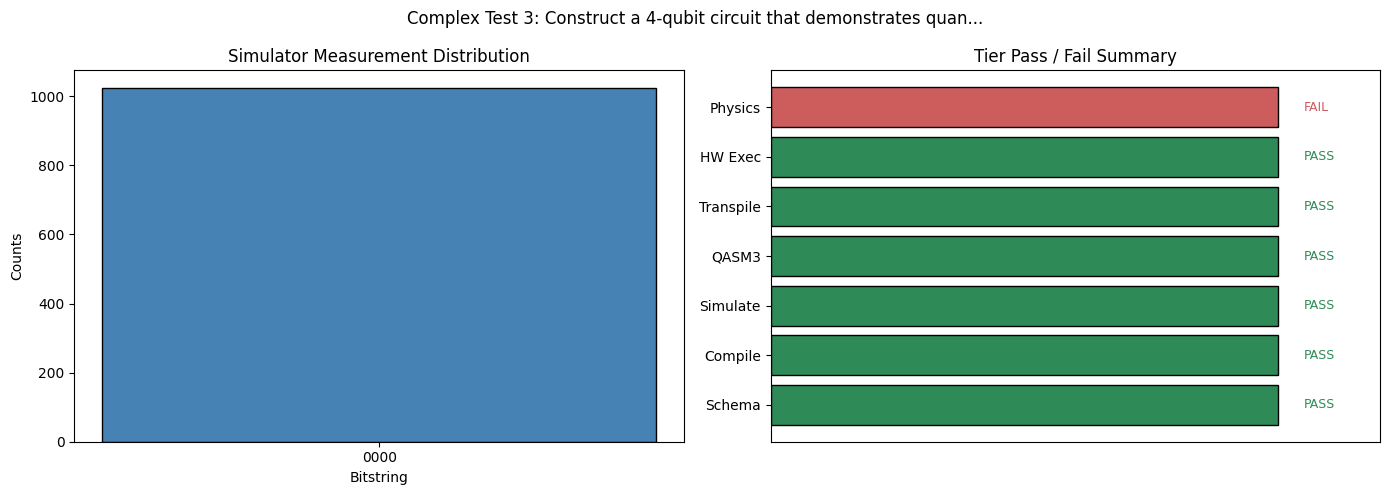


  COMPLEX TEST 4/5
  Goal: Create a 5-qubit circuit that encodes a logical qubit into 3 physical qubits (qu...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:19:07-INFO ======
SUCCESS


  0%|          | 0/2 [00:22<?, ?it/s]

Raw LLM output:
{
  "num_qubits": 5,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "h", "targets": [1]},
    {"name": "h", "targets": [2]},
    {"name": "cx", "control": 0, "target": 3},
    {"name": "cx", "control": 1, "target": 4},
    {"name": "rz", "targets": [0], "theta": "pi/2"},
    {"name": "rz", "targets": [1], "theta": "-pi/2"},
    {"name": "cz", "control": 2, "target": 3},
    {"name": "cz", "control": 2, "target": 4},
    {"name": "h", "targets": [0]},
    {"name": "h", "targets": [1]},
    {"name": "measure", "targets": [0]},
    {"name": "measure", "targets": [1]},
    {"name": "measure", "targets": [2]},
    {"name": "measure", "targets": [3]},
    {"name": "measure", "targets": [4]}
  ]
}

  Tier 1 [Schema]: PASS  (5q, 16 gates)
  Tier 2 [Compilation]: PASS  (depth=4)
  Tier 3 [Simulation]: PASS  (32 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (181 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=20, 2q gates=4)


  Tier 6 [Hardware Exec]: PASS  (32 outcomes)
  Tier 7 [Physics]: PASS  (MW=2.0000, H=4.980 bits)
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 5
  num_gates  = 16

[Tier 2  Compilation]  pass=True
  logical depth      = 4
  logical gate counts = {'h': 5, 'cx': 2, 'rz': 2, 'cz': 2}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 32
  top-3 outcomes    = [('10001', 48), ('11110', 43), ('01010', 41)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 181 chars

[Tier 5  Transpilation]  pass=True
  ISA depth         = 20
  2-qubit gate count = 4
  ISA gate counts    = {'rz': 26, 'sx': 17, 'ecr': 4}

[Tier 6  Hardware Exec]  pass=True
  distinct outcomes = 32

[Tier 7  Physics Metrics]  pass=True
  Meyer-Wallach          = 2.000000
  Entanglement entropy   = 1.000000  (mean over qubits)
  Distribution entropy   = 4.9796 bits
  KL div vs uniform      = 0.019225



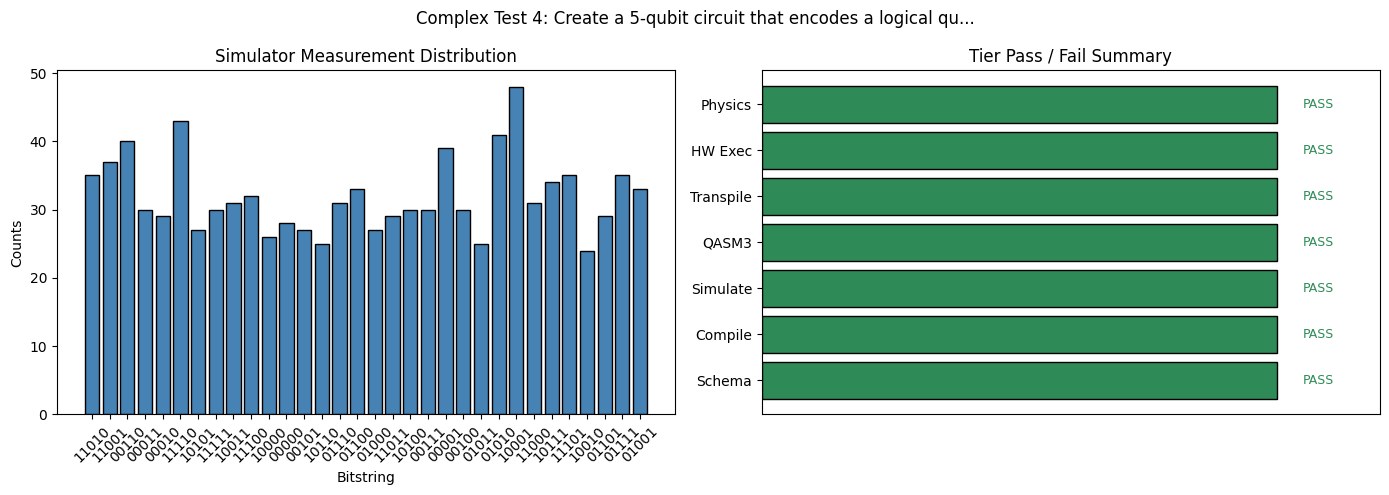


  COMPLEX TEST 5/5
  Goal: Propose a 5-qubit circuit that achieves Meyer-Wallach entanglement above 0.8 usi...



  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:19:24-INFO ======
SUCCESS


  0%|          | 0/2 [00:13<?, ?it/s]

Raw LLM output:
{
  "num_qubits": 5,
  "gates": [
    {"name": "h", "targets": [0]},
    {"name": "rz", "targets": [1], "theta": "pi/3"},
    {"name": "h", "targets": [2]},
    {"name": "ry", "targets": [3], "theta": "pi/5"},
    {"name": "cz", "control": 4, "target": 0},
    {"name": "rz", "targets": [2], "theta": "-pi/3"},
    {"name": "h", "targets": [3]},
    {"name": "rx", "targets": [1], "theta": "-pi/5"}
  ]
}

  Tier 1 [Schema]: PASS  (5q, 8 gates)
  Tier 2 [Compilation]: PASS  (depth=2)
  Tier 3 [Simulation]: PASS  (16 distinct outcomes)
  Tier 4 [QASM 3.0]: PASS  (151 chars)
  Tier 5 [Transpilation]: PASS  (ISA depth=7, 2q gates=1)


  Tier 6 [Hardware Exec]: PASS  (26 outcomes)
  Tier 7 [Physics]: PASS  (MW=0.0000, H=3.224 bits)
  EVALUATION REPORT  --  highest tier passed: 7 / 7

[Tier 1  Schema]  pass=True
  num_qubits = 5
  num_gates  = 8

[Tier 2  Compilation]  pass=True
  logical depth      = 2
  logical gate counts = {'h': 3, 'rz': 2, 'ry': 1, 'cz': 1, 'rx': 1}

[Tier 3  Simulation]  pass=True
  distinct outcomes = 16
  top-3 outcomes    = [('00000', 190), ('00001', 181), ('00101', 176)]

[Tier 4  QASM 3.0]  pass=True
  QASM length = 151 chars

[Tier 5  Transpilation]  pass=True
  ISA depth         = 7
  2-qubit gate count = 1
  ISA gate counts    = {'rz': 11, 'sx': 7, 'ecr': 1, 'x': 1}

[Tier 6  Hardware Exec]  pass=True
  distinct outcomes = 26

[Tier 7  Physics Metrics]  pass=True
  Meyer-Wallach          = 0.000000
  Entanglement entropy   = 0.000000  (mean over qubits)
  Distribution entropy   = 3.2241 bits
  KL div vs uniform      = 1.624213



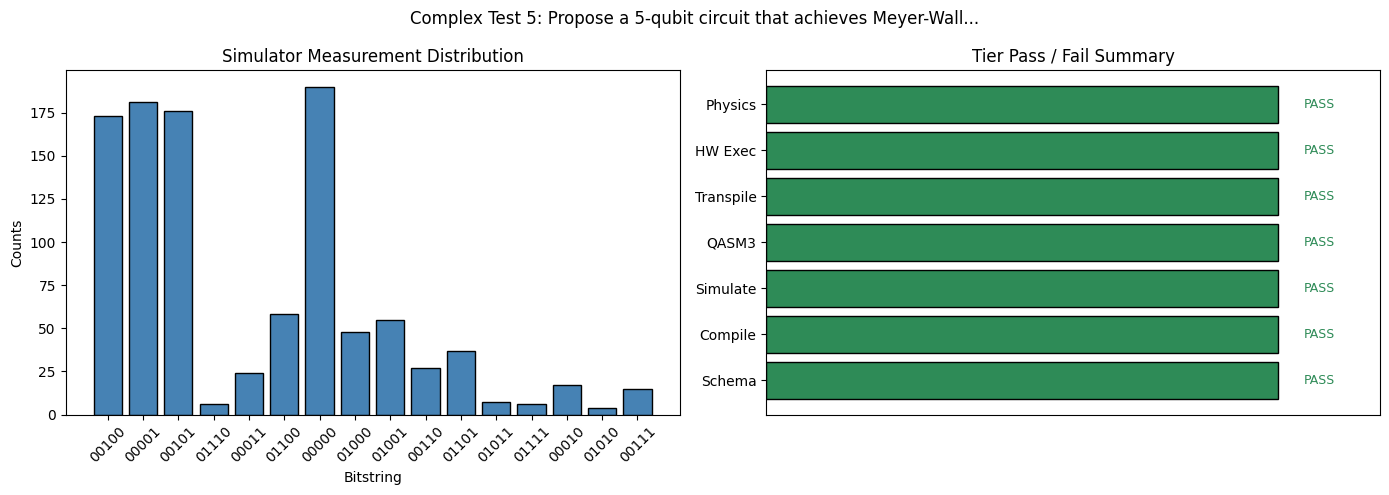


  COMPLEX STRESS-TEST SUMMARY
  Test 1: Tier 7/7  MW=0.0000  -- Design a 6-qubit circuit that creates a W-state-like su...
  Test 2: Tier 7/7  MW=0.2463  -- Build an 8-qubit hardware-efficient variational ansatz ...
  Test 3: Tier 6/7  MW=0.0000  -- Construct a 4-qubit circuit that demonstrates quantum p...
  Test 4: Tier 7/7  MW=2.0000  -- Create a 5-qubit circuit that encodes a logical qubit i...
  Test 5: Tier 7/7  MW=0.0000  -- Propose a 5-qubit circuit that achieves Meyer-Wallach e...


In [53]:
# ── Run complex stress tests with full hardware tiers ─────────────────────────
complex_results = []

for idx, goal in enumerate(COMPLEX_GOALS):
    print(f"\n{'='*70}")
    print(f"  COMPLEX TEST {idx+1}/{len(COMPLEX_GOALS)}")
    print(f"  Goal: {goal[:80]}...")
    print(f"{'='*70}\n")

    session.reset()
    raw = generate_circuit(goal)
    print(f"Raw LLM output:\n{raw}\n")

    rpt = evaluate_circuit(raw, run_hardware=True, verbose=True)
    print_report(rpt)
    plot_evaluation(rpt, title=f"Complex Test {idx+1}: {goal[:50]}...")
    complex_results.append({"goal": goal, "report": rpt})

# ── Summary across all complex tests ─────────────────────────────────────────
print(f"\n{'='*70}")
print("  COMPLEX STRESS-TEST SUMMARY")
print(f"{'='*70}")
for idx, cr in enumerate(complex_results):
    ht = cr["report"].get("highest_tier_passed", 0)
    mw = cr["report"].get("tier7", {}).get("details", {}).get("meyer_wallach")
    mw_str = f"MW={mw:.4f}" if mw is not None else "MW=N/A"
    print(f"  Test {idx+1}: Tier {ht}/7  {mw_str}  -- {cr['goal'][:55]}...")
print(f"{'='*70}")

---

## 11. Batch Generation and Success-Rate Tracking

To measure the syntactic-correctness rate (analogous to Agent-Q Table II),
generate multiple circuits and record how many pass each tier.

In [29]:
def batch_evaluate(
    goals: List[str],
    run_hardware: bool = False,
    verbose_per_circuit: bool = False,
) -> Dict[str, Any]:
    """Generate and evaluate one circuit per goal, collecting aggregate stats.

    Parameters
    ----------
    goals : list of str
        One prompt string per circuit to generate.
    run_hardware : bool
        Whether to include tiers 5-6 (slower).
    verbose_per_circuit : bool
        Print per-circuit tier output.

    Returns
    -------
    dict with 'results' (list of per-circuit reports) and 'summary' (aggregate).
    """
    results = []
    tier_pass_counts = {f"tier{i}": 0 for i in range(1, 8)}

    for idx, goal in enumerate(goals):
        print(f"[{idx+1}/{len(goals)}] {goal[:60]}...", end="  ")
        session.reset()
        raw = generate_circuit(goal)
        report = evaluate_circuit(raw, run_hardware=run_hardware,
                                  verbose=verbose_per_circuit)
        ht = report.get("highest_tier_passed", 0)
        print(f"highest tier = {ht}")
        results.append(report)

        for t in range(1, 8):
            key = f"tier{t}"
            if key in report and report[key]["pass"]:
                tier_pass_counts[key] += 1

    n = len(goals)
    summary = {
        "total": n,
        "pass_rates": {k: v / n for k, v in tier_pass_counts.items()},
        "raw_counts": tier_pass_counts,
    }

    print("\n--- Batch Summary ---")
    for tier_key in sorted(summary["pass_rates"]):
        tier_num = tier_key.replace("tier", "")
        rate = summary["pass_rates"][tier_key]
        print(f"  Tier {tier_num}: {summary['raw_counts'][tier_key]}/{n}  ({rate:.0%})")

    return {"results": results, "summary": summary}


print("Batch evaluation ready.")

Batch evaluation ready.


In [30]:
# ── Run a small batch (skipping hardware tiers for speed) ─────────────────────
BATCH_GOALS = [
    "Design a 3-qubit circuit with partial entanglement between qubits 0 and 2",
    "Create a 4-qubit circuit that produces interference in the computational basis",
    "Build a shallow 2-qubit variational ansatz with one rotation layer",
    "Construct a 5-qubit circuit that entangles non-adjacent qubits",
    "Propose a 3-qubit circuit that maximises Meyer-Wallach entanglement",
]

batch_result = batch_evaluate(BATCH_GOALS, run_hardware=False)

[1/5] Design a 3-qubit circuit with partial entanglement between q...  

  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:01:03-INFO ======
SUCCESS


  0%|          | 0/2 [00:07<?, ?it/s]


highest tier = 7
[2/5] Create a 4-qubit circuit that produces interference in the c...  

  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:01:16-INFO ======
SUCCESS


  0%|          | 0/2 [00:12<?, ?it/s]


highest tier = 7
[3/5] Build a shallow 2-qubit variational ansatz with one rotation...  

  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:01:20-INFO ======
SUCCESS


  0%|          | 0/2 [00:04<?, ?it/s]


highest tier = 7
[4/5] Construct a 5-qubit circuit that entangles non-adjacent qubi...  

  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:01:31-INFO ======
SUCCESS


  0%|          | 0/2 [00:10<?, ?it/s]


highest tier = 7
[5/5] Propose a 3-qubit circuit that maximises Meyer-Wallach entan...  

  0%|          | 0/2 [00:00<?, ?it/s]

=== 02:01:37-INFO ======
SUCCESS


  0%|          | 0/2 [00:05<?, ?it/s]

highest tier = 7

--- Batch Summary ---
  Tier 1: 5/5  (100%)
  Tier 2: 5/5  (100%)
  Tier 3: 5/5  (100%)
  Tier 4: 5/5  (100%)
  Tier 5: 0/5  (0%)
  Tier 6: 0/5  (0%)
  Tier 7: 5/5  (100%)


---

## Summary

This module provides a self-contained pipeline for:

1. **Generating** quantum circuits via a local LLM (Mellea + Ollama).
2. **Evaluating** them through seven tiers of increasing rigour -- from JSON
   parsing through fake-hardware execution to physics-based quality scores.

### Evaluation metrics at a glance

| Metric | Source | What it measures |
|--------|--------|-----------------|
| Syntactic correctness (Tiers 1-4) | Agent-Q (arXiv 2504.11109) | Can the LLM produce valid, parseable circuit representations? |
| ISA depth and 2-qubit gate count (Tier 5) | Standard Qiskit transpilation | Hardware cost / expected noise |
| Meyer-Wallach $Q(\psi)$ (Tier 7) | Macarone-Palmieri & Lo Franco (arXiv 2602.03466) | Global entanglement of the output state |
| Von Neumann entropy $S(\rho_A)$ (Tier 7) | Quantum information theory | Entanglement between subsystems |
| Distribution entropy $H$ (Tier 7) | Shannon information theory | Richness of the measurement distribution |
| KL divergence $D_{KL}(P \| U)$ (Tier 7) | Agent-Q (arXiv 2504.11109) | Distance from the uniform distribution |

### Next steps (future modules)

- **MODULE 2**: Iterative refinement loop with LLM critique and score-difference
  feedback (drawing on the test-time learning approach of arXiv 2602.03466).
- **MODULE 3**: Physics-aware goal proposal and autonomous discovery.
- **MODULE 4**: LUCJ ansatz discovery for quantum chemistry (SQD pipeline).